In [41]:
import sys 
import os
import pathlib
import click
import hydra
import torch
import dill
import wandb
import json
from diffusion_policy.workspace.base_workspace import BaseWorkspace
from diffusion_policy.env_runner.robomimic_image_runner import RobomimicImageRunner

 
import numpy as np 
import collections 
import tqdm
import h5py
import math 
import wandb.sdk.data_types.video as wv
from diffusion_policy.gym_util.async_vector_env import AsyncVectorEnv
from diffusion_policy.gym_util.sync_vector_env import SyncVectorEnv
from diffusion_policy.gym_util.multistep_wrapper import MultiStepWrapper
from diffusion_policy.gym_util.video_recording_wrapper import VideoRecordingWrapper, VideoRecorder
from diffusion_policy.model.common.rotation_transformer import RotationTransformer

from diffusion_policy.policy.base_image_policy import BaseImagePolicy
from diffusion_policy.common.pytorch_util import dict_apply
from diffusion_policy.env_runner.base_image_runner import BaseImageRunner
from diffusion_policy.env.robomimic.robomimic_image_wrapper import RobomimicImageWrapper
import robomimic.utils.file_utils as FileUtils
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.obs_utils as ObsUtils 
from diffusion_policy.workspace.train_diffusion_unet_hybrid_workspace import TrainDiffusionUnetHybridWorkspace

import h5py
import matplotlib.pyplot as plt

In [10]:
from collections import defaultdict, deque

class FrameStackForTrans:
    def __init__(self, num_frames):
        self.num_frames = num_frames
        self.obs_history = {}
        
    def reset(self, init_obs):
        """ 
        init_obs: dict of initial observation at the start of the episode
        return stacked obs by repeating the first observation num_frames times
        """
        
        self.obs_history = {}
        for k in init_obs:
            self.obs_history[k] = deque([init_obs[k][None] for _ in range(self.num_frames)], maxlen=self.num_frames,)
        obs = { k : np.concatenate(self.obs_history[k], axis=0) for k in self.obs_history }
        return obs 

    def add_new_obs(self, new_obs):
        """ 
        new_obs: dict of new observation at current timestep
        return stacked obs
        """
        for k in new_obs:
            if 'timesteps' in k or 'actions' in k: continue
            self.obs_history[k].append(new_obs[k][None])

        obs= { k : np.concatenate(self.obs_history[k], axis=0) for k in self.obs_history }
        return obs 

In [2]:
checkpoint = "data/outputs/2024.11.03/01.29.56_train_diffusion_unet_hybrid_lift_image/checkpoints/epoch=0550-test_mean_score=0.940.ckpt"
device = "cuda:0"

In [3]:
payload = torch.load(open(checkpoint, 'rb'), pickle_module=dill)
cfg = payload['cfg'] 
workspace = TrainDiffusionUnetHybridWorkspace(cfg, output_dir=None)
workspace: BaseWorkspace
workspace.load_payload(payload, exclude_keys=None, include_keys=None)


============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['robot0_eef_quat', 'robot0_gripper_qpos', 'robot0_eef_pos']
using obs modality: rgb with keys: ['robot0_eye_in_hand_image', 'agentview_image']
using obs modality: depth with keys: []
using obs modality: scan with keys: []


/home/ns1254/miniforge3/envs/robodiff/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ns1254/miniforge3/envs/robodiff/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Diffusion params: 2.556120e+08
Vision params: 2.239418e+07


In [4]:
# get policy from workspace
policy = workspace.model
if cfg.training.use_ema:
    policy = workspace.ema_model

device = torch.device(device)
policy.to(device)
policy.eval()
pass 

In [30]:
rotation_transformer = RotationTransformer('axis_angle', 'rotation_6d')

def undo_transform_action( action):
    raw_shape = action.shape
    if raw_shape[-1] == 20:
        # dual arm
        action = action.reshape(-1,2,10)

    d_rot = action.shape[-1] - 4
    pos = action[...,:3]
    rot = action[...,3:3+d_rot]
    gripper = action[...,[-1]]
    rot = rotation_transformer.inverse(rot)
    uaction = np.concatenate([
        pos, rot, gripper
    ], axis=-1)

    if raw_shape[-1] == 20:
        # dual arm
        uaction = uaction.reshape(*raw_shape[:-1], 14)

    return uaction


In [7]:
dataset_path="/home/ns1254/data_robomimic/lift/ph/image_v141_f40_abs.hdf5"

f= h5py.File(dataset_path, 'r')
demos= f['data']
len(demos)

40

In [42]:
demo=f['data']['demo_1']
actions_org=demo['actions']
obss=demo['obs']
actions_org.shape

(58, 7)

In [31]:
framestacker=FrameStackForTrans(2)
keys_select = ['agentview_image', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_eye_in_hand_image', 'robot0_gripper_qpos']


In [33]:
def predict_action(obs):
    """ 
    obs: 2x...
    """
    np_obs_dict = {key:obs[key] for key in keys_select}
    obs_dict = dict_apply(np_obs_dict, 
        lambda x: torch.from_numpy(x).to(
            device=device))

    for key in obs_dict.keys():
        obs_dict[key]=obs_dict[key].unsqueeze(0) 

    
    with torch.no_grad():
        action_dict = policy.predict_action(obs_dict)

    # device_transfer
    np_action_dict = dict_apply(action_dict, lambda x: x.detach().to('cpu').numpy())


    # step env
    env_action =  np_action_dict['action']
    env_action = undo_transform_action(env_action)

    env_action=env_action.squeeze()
    return env_action

In [ ]:
actions_preds=[]
for i in range(0, actions_org.shape[0], 8): 
    obs = {k: obss[k][i] for k in obss.keys()}
    obs['agentview_image'] = obs['agentview_image'].transpose(2,0,1)
    obs['robot0_eye_in_hand_image'] = obs['robot0_eye_in_hand_image'].transpose(2,0, 1)
    
    if i==0:
        obs = framestacker.reset(obs)
    else:
        obs = framestacker.add_new_obs(obs)
    
    action_pred=predict_action(obs)
    actions_preds.extend(action_pred)

actions_preds=np.array(actions_preds)[:actions_org.shape[0]]
actions_preds.shape

(58, 7)

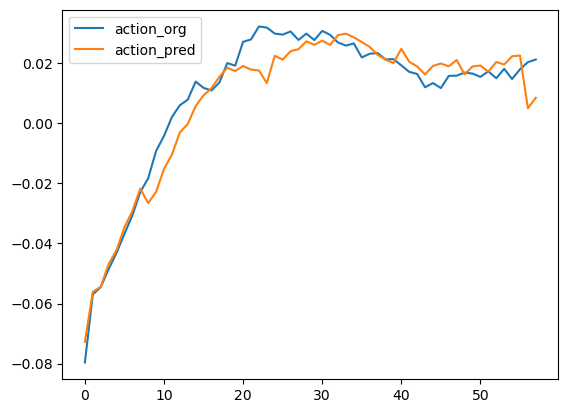

In [45]:
plt.plot(actions_org[:, 0], label="action_org")
plt.plot(actions_preds[:, 0], label="action_pred")
plt.legend()

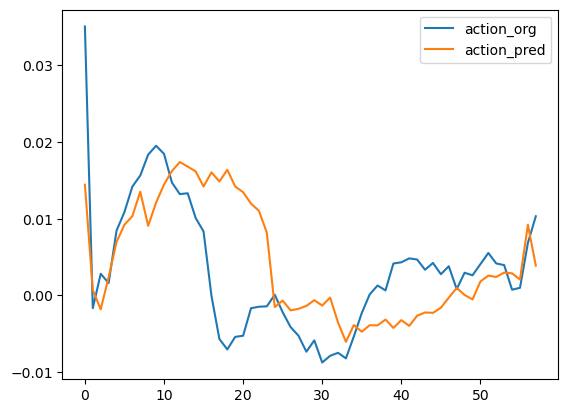

In [46]:
plt.plot(actions_org[:, 1], label="action_org")
plt.plot(actions_preds[:, 1], label="action_pred")
plt.legend()

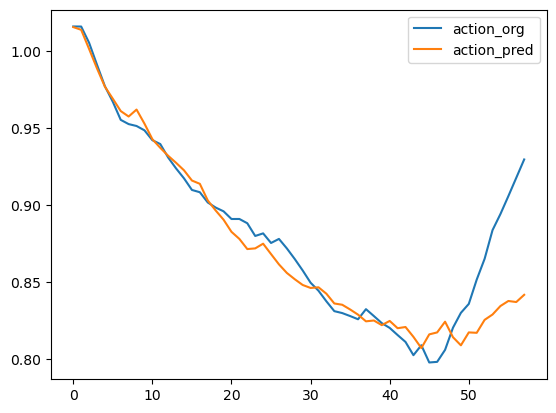

In [47]:
plt.plot(actions_org[:, 2], label="action_org")
plt.plot(actions_preds[:, 2], label="action_pred")
plt.legend()